IMPORTAÇÕES NECESSÁRIAS

In [24]:
import sys
import os
sys.path.append(os.path.abspath('../scripts'))
from myFunctions import install_packages
install_packages()

Installing required packages: ['numpy', 'pandas', 'scikit-learn', 'joblib', 'pyarrow', 'fastparquet', 'plotly', 'matplotlib', 'MetaTrader5', 'tabulate', 'optuna', 'torch', 'tqdm', 'shap', 'kaleido']
numpy is already installed.
pandas is already installed.
scikit-learn is already installed.
joblib is already installed.
pyarrow is already installed.
fastparquet is already installed.
plotly is already installed.
matplotlib is already installed.
MetaTrader5 is already installed.
tabulate is already installed.
optuna is already installed.
torch is already installed.
tqdm is already installed.
shap is already installed.
kaleido is already installed.
All packages are verified.


In [25]:
import sys
import subprocess
import pkg_resources
import os

def install_packages():
    required_packages = [
        "numpy",
        "pandas",
        "scikit-learn",
        "joblib",
        "pyarrow",
        "fastparquet",
        "plotly",
        "matplotlib",
        "MetaTrader5",
        "tabulate",
        "optuna",
        "torch",
        "tqdm",
        "shap",
        "kaleido"
    ]
    
    print(f'Installing required packages: {required_packages}')
    # Checking installed packages
    installed_packages = {pkg.key for pkg in pkg_resources.working_set}
    
    # Install missing packages
    for package in required_packages:
        try:
            if package.lower() not in installed_packages:
                print(f"Installing {package}...")
                subprocess.check_call([sys.executable, "-m", "pip", "install", package])
            else:
                print(f"{package} is already installed.")
        except Exception as e:
            print(f"Error installing {package}: {e}")
            continue  # Continue with other packages, log the error but don't stop the process
    
    print("All packages are verified.")
install_packages()

Installing required packages: ['numpy', 'pandas', 'scikit-learn', 'joblib', 'pyarrow', 'fastparquet', 'plotly', 'matplotlib', 'MetaTrader5', 'tabulate', 'optuna', 'torch', 'tqdm', 'shap', 'kaleido']
numpy is already installed.
pandas is already installed.
scikit-learn is already installed.
joblib is already installed.
pyarrow is already installed.
fastparquet is already installed.
plotly is already installed.
matplotlib is already installed.
MetaTrader5 is already installed.
tabulate is already installed.
optuna is already installed.
torch is already installed.
tqdm is already installed.
shap is already installed.
kaleido is already installed.
All packages are verified.


In [26]:
### importing required packages
from tabulate import tabulate
import pandas as pd
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm

import kaleido
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error, accuracy_score
from torch.utils.data import DataLoader, TensorDataset
import optuna
import optuna.visualization as vis
import os
import joblib
import matplotlib.pyplot as plt


### MODEL CLASSES DEFINITION

In [27]:
class LSTMModel(nn.Module):
    """
    LSTM-based model for time-series tasks, supporting regression and classification.

    Args:
        input_size (int): Number of input features per time step.
        hidden_size (int): Number of hidden units in each LSTM layer.
        num_layers (int): Number of LSTM layers.
        dropout (float): Dropout rate for regularization.
        target (str): Target type ('price' for regression, 'behavior' for classification).
    """
    def __init__(self, input_size, hidden_size, num_layers, dropout, target):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        if 'behavior' in target:
            self.fc = nn.Sequential(
                nn.Linear(hidden_size, hidden_size // 2),
                nn.ReLU(),
                nn.Linear(hidden_size // 2, 2)
            )
        else:
            self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        output = self.fc(hidden[-1])
        return output

class GRUModel(nn.Module):
    """
    GRU-based model for time-series tasks, supporting regression and classification.

    Args:
        input_size (int): Number of input features per time step.
        hidden_size (int): Number of hidden units in each GRU layer.
        num_layers (int): Number of GRU layers.
        dropout (float): Dropout rate for regularization.
        target (str): Target type ('price' for regression, 'behavior' for classification).
    """
    def __init__(self, input_size, hidden_size, num_layers, dropout, target):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        if 'behavior' in target:
            self.fc = nn.Sequential(
                nn.Linear(hidden_size, hidden_size // 2),
                nn.ReLU(),
                nn.Linear(hidden_size // 2, 2)
            )
        else:
            self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        _, hidden = self.gru(x)
        output = self.fc(hidden[-1])
        return output

class CNNLSTMModel(nn.Module):
    """
    Hybrid CNN-LSTM model for time-series tasks, supporting regression and classification.

    Args:
        input_size (int): Number of input features per time step.
        hidden_size (int): Number of hidden units in each LSTM layer.
        num_layers (int): Number of LSTM layers.
        dropout (float): Dropout rate for regularization.
        conv_filters (int): Number of filters in the 1D convolutional layer.
        target (str): Target type ('price' for regression, 'behavior' for classification).
    """
    def __init__(self, input_size, hidden_size, num_layers, dropout, conv_filters, target):
        super(CNNLSTMModel, self).__init__()
        self.conv1d = nn.Conv1d(in_channels=input_size, out_channels=conv_filters, kernel_size=3, stride=1, padding=1)
        self.lstm = nn.LSTM(conv_filters, hidden_size, num_layers, batch_first=True, dropout=dropout)
        if 'behavior' in target:
            self.fc = nn.Sequential(
                nn.Linear(hidden_size, hidden_size // 2),
                nn.ReLU(),
                nn.Linear(hidden_size // 2, 2)
            )
        else:
            self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.conv1d(x)
        x = x.permute(0, 2, 1)
        _, (hidden, _) = self.lstm(x)
        output = self.fc(hidden[-1])
        return output

class CNNGRUModel(nn.Module):
    """
    Hybrid CNN-GRU model for time-series tasks, supporting regression and classification.

    Args:
        input_size (int): Number of input features per time step.
        hidden_size (int): Number of hidden units in each GRU layer.
        num_layers (int): Number of GRU layers.
        dropout (float): Dropout rate for regularization.
        conv_filters (int): Number of filters in the 1D convolutional layer.
        target (str): Target type ('price' for regression, 'behavior' for classification).
    """
    def __init__(self, input_size, hidden_size, num_layers, dropout, conv_filters, target):
        super(CNNGRUModel, self).__init__()
        self.conv1d = nn.Conv1d(in_channels=input_size, out_channels=conv_filters, kernel_size=3, stride=1, padding=1)
        self.gru = nn.GRU(conv_filters, hidden_size, num_layers, batch_first=True, dropout=dropout)
        if 'behavior' in target:
            self.fc = nn.Sequential(
                nn.Linear(hidden_size, hidden_size // 2),
                nn.ReLU(),
                nn.Linear(hidden_size // 2, 2)
            )
        else:
            self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.conv1d(x)
        x = x.permute(0, 2, 1)
        _, hidden = self.gru(x)
        output = self.fc(hidden[-1])
        return output

### PROCESSING DATA TO ARRAYS FOR WINDOWS SIZE AND LOOK FORWARD

In [28]:
def scale_features(df, exclude_columns=['date', 'day']):
    """
    Escalona todas as colunas do DataFrame, exceto as especificadas em exclude_columns.

    Parameters:
        df (pd.DataFrame): O DataFrame contendo os dados.
        exclude_columns (list): Lista de colunas que não serão escalonadas.

    Returns:
        df_scaled (pd.DataFrame): DataFrame com as colunas escalonadas.
        scalers (dict): Dicionário contendo os escaladores para cada coluna escalonada.
    """
    scalers = {}
    columns_to_scale = [col for col in df.columns if col not in exclude_columns]
    
    df_scaled = df.copy()
    for col in columns_to_scale:
        scaler = MinMaxScaler()
        df_scaled[col] = scaler.fit_transform(df[[col]])
        scalers[col] = scaler
    
    return df_scaled, scalers


def data_to_array(df, window_size, target, features):
    """
    Prepares X and y with targets shifted for the next day after the window.

    Parameters:
        df (pd.DataFrame): The dataframe containing the data.
        window_size (int): The window size (e.g., 7 days).
        target (str): The target column name (e.g., 'close_price_target').
        features (list): List of feature column names (e.g., ['open', 'high', 'low', 'close']).

    Returns:
        X (np.ndarray): Input features.
        y (np.ndarray): Target values.
        y_dates (np.ndarray): Dates associated with the targets.
    """
    X = []
    y = []
    y_dates = []

    for i in range(len(df) - window_size):
        # Access the target column directly by its name
        target_value = df.iloc[i + window_size][target]
        y.append(target_value)
        y_dates.append(df.iloc[i + window_size]['date'])
        
        # Prepare the features using the provided column names
        X.append(df.iloc[i:i + window_size][features].values)

    return np.array(X), np.array(y), np.array(y_dates)

SPLITING DATA TO TRAIN AND TEST


In [29]:
def segment_data(df, test_size=0.15):
    """
    Segments the data into training and test sets based on the test size percentage.

    Args:
        df (pd.DataFrame): The DataFrame to be segmented.
        test_size (float): The percentage of data to be used for testing.

    Returns:
        pd.DataFrame: Training data.
        pd.DataFrame: Testing data.
    """

    # Calculates the size of the test set
    test_len = int(len(df) * test_size)
    
    # Segments the data
    train_data = df[:-test_len]  # 85% for training
    test_data = df[-test_len:]   # 15% for testing
    
    return train_data,test_data

### Training and Testing Pipeline

In [38]:
def train_evaluate_model(trial, X_train, y_train, X_test, y_test, target, window_size, look_forward, model_type, study_name, model_dir):
    """
    Optimizes models using Optuna for hyperparameter tuning. Optimizes based on AUC score for binary classification tasks.

    Args:
        X_train (DataFrame): The training data features.
        y_train (DataFrame): The training data target labels.
        X_test (DataFrame): The test data features.
        y_test (DataFrame): The test data target labels.
        target (str): The target variable ('price' or 'behavior').
        window_size (int): Size of the window for input data.
        look_forward (int): Look-ahead for prediction.
        model_type (str): Type of the model to train (LSTM, GRU, etc.).
        study_name (str): Name of the study for saving results.
        model_dir (str): Directory to save model-related files.

    Returns:
        float: The evaluation error (e.g., AUC score or MSE).
    """

    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.long if 'behavior' in target else torch.float32)  # Changed to long for behavior
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.long if 'behavior' in target else torch.float32)  # Changed to long for behavior

    epochs = trial.suggest_int('epochs', 200, 1000)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    dropout = trial.suggest_float('dropout', 0.2, 0.5)
    num_layers = trial.suggest_int('num_layers', 1, 3)
    hidden_size = trial.suggest_int('hidden_size', 16, 256)

    if model_type in ['CNN-LSTM', 'CNN-GRU']:
        conv_filters = trial.suggest_categorical('conv_filters', [32, 64, 128])

    # Initialize model based on type
    if model_type == 'LSTM':
        model = LSTMModel(input_size=X_train.shape[2], hidden_size=hidden_size, num_layers=num_layers, dropout=dropout, target=target)
    elif model_type == 'GRU':
        model = GRUModel(input_size=X_train.shape[2], hidden_size=hidden_size, num_layers=num_layers, dropout=dropout, target=target)
    elif model_type == 'CNN-LSTM':
        model = CNNLSTMModel(input_size=X_train.shape[2], hidden_size=hidden_size, num_layers=num_layers, dropout=dropout, conv_filters=conv_filters, target=target)
    elif model_type == 'CNN-GRU':
        model = CNNGRUModel(input_size=X_train.shape[2], hidden_size=hidden_size, num_layers=num_layers, dropout=dropout, conv_filters=conv_filters, target=target)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    # Select criterion based on target
    criterion = nn.CrossEntropyLoss() if 'behavior' in target else nn.MSELoss()

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=False)
    average_losses = {epoch: [] for epoch in range(epochs)}

    # Loop de treinamento
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(X_batch)
            
            if target == 'behavior_target':  # Flatten para CrossEntropyLoss
                output = output.view(-1, 2)  # Garantindo que a saída tem 2 classes para cada batch
                y_batch = y_batch.view(-1)  # Flatten y_batch para ser compatível com CrossEntropy

            loss = criterion(output, y_batch)
           
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            

        avg_loss = total_loss / len(train_loader)
        average_losses[epoch].append(avg_loss)
        if epoch  %  50  == 0: 
            print(f'{epoch} loss: {avg_loss}')

    # Evaluation on test data
    model.eval()
    test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)
    predictions = []
    true_values = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            output = model(X_batch)
            if 'behavior' in target:
                _, predicted = torch.max(output, 1)  # Get the class with highest probability
            else:
                predicted = output
                
            predictions.append(predicted.numpy())
            true_values.append(y_batch.numpy())
                        
    predictions = np.concatenate(predictions, axis=0)
    true_values = np.concatenate(true_values, axis=0)

    # Calculate error based on target
    if 'price' in target:
        error = mean_squared_error(true_values, predictions)
    else:
        error = roc_auc_score(y_test.numpy(), predictions)

    # Save loss decay file
    loss_decay_file = os.path.join(model_dir, f"{study_name}_loss_decay.pkl")
    with open(loss_decay_file, 'wb') as f:
        joblib.dump(average_losses, f)

    # Plot and save loss decay graph
    plt.figure(figsize=(10, 6))
    plt.plot(range(epochs), [np.mean(loss) for loss in average_losses.values()], label='Average Training Loss')
    plt.title(f'Loss Decay Over Epochs for {study_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Save the plot as an image
    loss_plot_file = os.path.join(model_dir, f"{study_name}_loss_decay_plot.png")
    plt.savefig(loss_plot_file)
    plt.close()

    return error

In [39]:
def optimize_models(df: pd.DataFrame, 
                    targets: list, 
                    features: list, 
                    look_backs: list, 
                    look_forwards: list, 
                    target_dir: str = None, 
                    models: list = None, 
                    max_samples: int= 100):
    """
    Optimizes models using Optuna for hyperparameter tuning. Optimizes based on AUC or RMSE depending on the target type.

    Args:
        df (DataFrame): The data to be used for training.
        targets (list): List of target columns to be used in training.
        target_dir (str): The name of the directory to save optuna studies 
        features (list): List of features to be used for training.
        look_backs (list): List of window sizes for the sliding window approach.
        look_forwards (list): List of look-forward values for forecasting.
        max_samples (int): The maximum number of Optuna trials to perform.

    Returns:
        dict: A dictionary containing study results, including best parameters and model directories.
    """
    study_results = {}
    
    if target_dir is not None:
        input_dir = os.path.join('..', 'data', 'models', target_dir).replace("/", "\\")
    else:
        input_dir = os.path.join('..', 'data', 'models').replace("/", "\\")
    
    if not os.path.exists(input_dir):
        os.makedirs(input_dir)
    
    exclude_columns = ['date', 'day']
    df_scaled, _ = scale_features(df, exclude_columns)
    train_data, test_data = segment_data(df_scaled, test_size=0.15)
    
    for window_size in look_backs:
        for look_forward in look_forwards:
            for target in targets:
                X_train, y_train, y_dates = data_to_array(train_data.copy(), 
                                                          window_size,
                                                          target, 
                                                          features)

                X_test, y_test, _ = data_to_array(test_data.copy(), 
                                                  window_size, 
                                                  target, 
                                                  features)

                if models == None:
                    models = models = ['LSTM', 'GRU', 'CNN-LSTM', 'CNN-GRU']
                
                for model_type in tqdm(models):
                    study_name = f"{model_type}_look_back_{window_size}_look_forward_{look_forward}_{target}"
                    model_dir = os.path.join(input_dir, study_name).replace("/", "\\")
                    
                    if not os.path.exists(model_dir):
                        os.makedirs(model_dir)
                    
                    # Define optimization direction
                    direction = 'minimize' if 'price' in target else 'maximize'
                        
                    # Creating the Optuna study
                    study = optuna.create_study(direction=direction, study_name=study_name)
                    study.optimize(
                        lambda trial: train_evaluate_model(
                            trial, X_train, y_train, X_test, y_test, target, window_size, look_forward, model_type, study_name, model_dir
                        ),
                        n_trials=max_samples
                    )

                    study_file = os.path.join(model_dir, f"{study_name}_study.pkl").replace("/", "\\")
                    joblib.dump(study, study_file)
                    print(f'{study_name} saved to {study_file}')

                    best_params = study.best_params
                    best_trial_index = study.best_trial.number 
                    best_trial_value = study.best_value  

                    best_params_dict = {
                        'best_params': best_params,
                        'best_trial_index': best_trial_index,
                        'best_trial_value': best_trial_value
                    }
                    params_file = os.path.join(model_dir, f"{study_name}_best_params.pkl").replace("/", "\\")
                    with open(params_file, "wb") as f:
                        joblib.dump(best_params_dict, f)

                    try:
                        fig_optimization = vis.plot_optimization_history(study)
                        fig_optimization.write_image(os.path.join(model_dir, f"{study_name}_optimization_history.png"))

                        fig_importances = vis.plot_param_importances(study)
                        fig_importances.write_image(os.path.join(model_dir, f"{study_name}_param_importances.png"))

                        fig_slice = vis.plot_slice(study)
                        fig_slice.write_image(os.path.join(model_dir, f"{study_name}_slice_plot.png"))
                        print(f"Images saved to {model_dir}")
                    except Exception as e:
                        print(f"Error in plotting images for {study_name}: {e}")


                    print(f"Saved to {model_dir}:")
                    print(f"Best hyperparameters for {model_type}, lookback: {window_size}, look forward: {look_forward}, target {target}: {best_params}")
                    print(f"Best trial index: {best_trial_index}, Best trial value: {best_trial_value}")

                    study_results[study_name] = {
                        "study": study,
                        "best_params": best_params,
                        "best_trial_index": best_trial_index,
                        "best_trial_value": best_trial_value,
                        "directory": model_dir
                    }

    return study_results


In [ ]:

input_dir = os.path.join('..', 'data', 'processed')

features_name = 'daily_features.pkl'
input_dir_features = os.path.join('..', 'data', 'features')

df_daily = pd.read_parquet(os.path.join(input_dir, 'df_daily.parquet')).replace("/", "\\")
df2 = pd.read_parquet(os.path.join(input_dir, 'df_timestamp.parquet')).replace("/", "\\")
daily_features = joblib.load(os.path.join(input_dir_features, 'daily_features.pkl'))
timnestamp_features = joblib.load(os.path.join(input_dir_features, '15min_timestamp_features.pkl'))

models = ['LSTM', 'GRU', 'CNN-LSTM', 'CNN-GRU']
features = daily_features
targets = ['behavior_target', 'open_price_target', 'close_price_target']
sliding_windows = [7, 15, 30, 45, 60] 
look_forwards = [1]  

# Call the optimize_models function
study_results = optimize_models(df=df_daily,
                                targets=targets,
                                features=features, 
                                look_backs=sliding_windows,
                                look_forwards=look_forwards,
                                target_dir='daily', 
                                max_samples=100)


  0%|          | 0/4 [00:00<?, ?it/s][I 2024-12-24 16:22:57,942] A new study created in memory with name: LSTM_look_back_7_look_forward_1_behavior_target
c:\Users\guilherme_trintinali\AppData\Local\anaconda3\envs\myenv\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.201784943698827 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 loss: 0.7013999462127686
50 loss: 0.5425910472869873
100 loss: 0.3855906628072262
150 loss: 0.23524606488645078
200 loss: 0.09301215894520283
250 loss: 0.02848733770661056


[I 2024-12-24 16:25:06,795] Trial 0 finished with value: 0.5456745311554749 and parameters: {'epochs': 281, 'batch_size': 128, 'learning_rate': 0.00015664709706185215, 'dropout': 0.201784943698827, 'num_layers': 1, 'hidden_size': 68}. Best is trial 0 with value: 0.5456745311554749.


0 loss: 0.6871935655088985
50 loss: 0.6729646745850059
100 loss: 0.6807663756258348
150 loss: 0.6642580312841079
200 loss: 0.6394934478928062
250 loss: 0.6213329329210169
300 loss: 0.5858830441446865
350 loss: 0.5781002342700958
400 loss: 0.5571898888139164
450 loss: 0.5246055774828967
500 loss: 0.4849419216899311
550 loss: 0.4695916202138452
600 loss: 0.6062657727914698
650 loss: 0.6133950931184432
700 loss: 0.48248228781363545
750 loss: 0.45475513970150666
800 loss: 0.52170270856689
850 loss: 0.4265202844844145
900 loss: 0.42879685496582703


[I 2024-12-24 16:56:40,690] Trial 1 finished with value: 0.5241984271022383 and parameters: {'epochs': 947, 'batch_size': 32, 'learning_rate': 0.00021851114052870164, 'dropout': 0.3103234167300018, 'num_layers': 3, 'hidden_size': 146}. Best is trial 0 with value: 0.5456745311554749.
c:\Users\guilherme_trintinali\AppData\Local\anaconda3\envs\myenv\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3150173939721488 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 loss: 0.689348664548662
50 loss: 0.6544231308831109
100 loss: 0.6784626377953423
150 loss: 0.6734987431102328
200 loss: 0.6581983963648478
250 loss: 0.5955882800949944
300 loss: 0.5048624376455942
350 loss: 0.5777310050196118
400 loss: 0.480887265668975
450 loss: 0.4288746962944667
500 loss: 0.404003332886431
550 loss: 0.27963235560390687


[I 2024-12-24 17:35:02,027] Trial 2 finished with value: 0.5093768905021173 and parameters: {'epochs': 585, 'batch_size': 64, 'learning_rate': 0.0007544725012968957, 'dropout': 0.3150173939721488, 'num_layers': 1, 'hidden_size': 149}. Best is trial 0 with value: 0.5456745311554749.


0 loss: 0.6876695487234328
50 loss: 0.6791253354814317
100 loss: 0.6859137879477607
150 loss: 0.6793382631407844
200 loss: 0.685829136106703
250 loss: 0.676429397530026
300 loss: 0.6858173741234673


[I 2024-12-24 17:58:28,671] Trial 3 finished with value: 0.5 and parameters: {'epochs': 302, 'batch_size': 64, 'learning_rate': 0.0012650154833088736, 'dropout': 0.22492228722201085, 'num_layers': 3, 'hidden_size': 182}. Best is trial 0 with value: 0.5456745311554749.


0 loss: 0.6850691795349121
50 loss: 0.6830156564712524
100 loss: 0.684350049495697
150 loss: 0.6856898188591003
200 loss: 0.6840284824371338
250 loss: 0.6802048802375793
300 loss: 0.6855558156967163
350 loss: 0.6841801643371582
400 loss: 0.6837492465972901
450 loss: 0.6840447425842285
500 loss: 0.6841183304786682


[I 2024-12-24 18:39:53,926] Trial 4 finished with value: 0.5 and parameters: {'epochs': 539, 'batch_size': 128, 'learning_rate': 0.0040768774124428, 'dropout': 0.4194506807097166, 'num_layers': 3, 'hidden_size': 53}. Best is trial 0 with value: 0.5456745311554749.


0 loss: 0.6864112734794616
50 loss: 0.6748087882995606
100 loss: 0.6756950497627259
150 loss: 0.673706591129303
200 loss: 0.6755930542945862
250 loss: 0.6644454598426819
300 loss: 0.6842204332351685
350 loss: 0.6822952151298523


[I 2024-12-24 19:11:51,196] Trial 5 finished with value: 0.5 and parameters: {'epochs': 398, 'batch_size': 128, 'learning_rate': 0.0011249085078378048, 'dropout': 0.23965903789118323, 'num_layers': 3, 'hidden_size': 199}. Best is trial 0 with value: 0.5456745311554749.


0 loss: 0.6872654942905202
50 loss: 0.6715211903347689
100 loss: 0.6599549931638381
150 loss: 0.6655796275419348
200 loss: 0.6407742675612954


[I 2024-12-24 19:14:35,793] Trial 6 finished with value: 0.5390199637023593 and parameters: {'epochs': 247, 'batch_size': 32, 'learning_rate': 0.0002096660312765543, 'dropout': 0.31809683694404906, 'num_layers': 3, 'hidden_size': 52}. Best is trial 0 with value: 0.5456745311554749.


0 loss: 0.6968512415885926
50 loss: 0.6856310606002808
100 loss: 0.6834131240844726
150 loss: 0.6841611623764038
200 loss: 0.6843810558319092
250 loss: 0.6840636134147644
300 loss: 0.6840984106063843
350 loss: 0.6841281890869141
400 loss: 0.6841092228889465
450 loss: 0.6841092944145203
500 loss: 0.6841092944145203
550 loss: 0.6841093182563782


[I 2024-12-24 20:11:10,693] Trial 7 finished with value: 0.5 and parameters: {'epochs': 584, 'batch_size': 128, 'learning_rate': 0.004327501557258895, 'dropout': 0.47302116974270975, 'num_layers': 3, 'hidden_size': 148}. Best is trial 0 with value: 0.5456745311554749.


0 loss: 0.6888724214890424
50 loss: 0.6868319160798017
100 loss: 0.6868581841973698
150 loss: 0.6868549971019521
200 loss: 0.6868551759158864
250 loss: 0.686855270582087
300 loss: 0.6868552740882424
350 loss: 0.6868552916190204
400 loss: 0.6868552916190204
450 loss: 0.6868552881128648
500 loss: 0.6868553056436426
550 loss: 0.6868553091497982
600 loss: 0.6868553091497982
650 loss: 0.6868553231744206
700 loss: 0.6868553266805761
750 loss: 0.6868553231744206
800 loss: 0.6868553231744206
850 loss: 0.6868553231744206


[I 2024-12-24 20:18:47,297] Trial 8 finished with value: 0.5 and parameters: {'epochs': 856, 'batch_size': 32, 'learning_rate': 0.009035920888542305, 'dropout': 0.3564068490287404, 'num_layers': 3, 'hidden_size': 30}. Best is trial 0 with value: 0.5456745311554749.


0 loss: 0.6896079659461976
50 loss: 0.6560905337333679
100 loss: 0.622877436876297
150 loss: 0.5347671270370483
200 loss: 0.633338475227356
250 loss: 0.4402512773871422
300 loss: 0.4784726083278656
350 loss: 0.41629285663366317
400 loss: 0.44337519705295564
450 loss: 0.41137698143720625
500 loss: 0.43752133250236513


[I 2024-12-24 20:36:31,672] Trial 9 finished with value: 0.49213551119177257 and parameters: {'epochs': 502, 'batch_size': 128, 'learning_rate': 0.0006509696956745281, 'dropout': 0.3126170456017328, 'num_layers': 2, 'hidden_size': 125}. Best is trial 0 with value: 0.5456745311554749.
c:\Users\guilherme_trintinali\AppData\Local\anaconda3\envs\myenv\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2086195164250025 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 loss: 0.6833595633506775
50 loss: 0.5313157737255096
100 loss: 0.3814586475491524
150 loss: 0.2129868444055319
200 loss: 0.10047949282452465
250 loss: 0.03936850321479142
300 loss: 0.017461604601703585
350 loss: 0.00878512414637953
400 loss: 0.005111124052200466
450 loss: 0.0032236087514320388
500 loss: 0.002141258184565231
550 loss: 0.0014821512020716909
600 loss: 0.0010557131958194078
650 loss: 0.0007677822628465947
700 loss: 0.0005661830662575084
750 loss: 0.0004329407965997234


[I 2024-12-24 20:44:11,429] Trial 10 finished with value: 0.5120992135511192 and parameters: {'epochs': 765, 'batch_size': 128, 'learning_rate': 0.00010636723493748743, 'dropout': 0.2086195164250025, 'num_layers': 1, 'hidden_size': 96}. Best is trial 0 with value: 0.5456745311554749.


0 loss: 0.6865486152031842
50 loss: 0.6689434472252341
100 loss: 0.6656815339537228
150 loss: 0.6538089303409352
200 loss: 0.6103128089624292


[I 2024-12-24 20:47:02,238] Trial 11 finished with value: 0.5632183908045977 and parameters: {'epochs': 207, 'batch_size': 32, 'learning_rate': 0.00024165540218086285, 'dropout': 0.38409330465709024, 'num_layers': 2, 'hidden_size': 70}. Best is trial 11 with value: 0.5632183908045977.


0 loss: 0.689954070483937
50 loss: 0.6778890595716589
100 loss: 0.6729509304551518
150 loss: 0.6131114959716797
200 loss: 0.5966682784697589


[I 2024-12-24 20:56:33,508] Trial 12 finished with value: 0.5012099213551119 and parameters: {'epochs': 207, 'batch_size': 32, 'learning_rate': 0.0002967683406391902, 'dropout': 0.3913247924133384, 'num_layers': 2, 'hidden_size': 246}. Best is trial 11 with value: 0.5632183908045977.
c:\Users\guilherme_trintinali\AppData\Local\anaconda3\envs\myenv\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.45714153393949586 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 loss: 0.6914013974806842
50 loss: 0.6433698219411513
100 loss: 0.6681642777779523
150 loss: 0.5020916742437026
200 loss: 0.4360026454224306
250 loss: 0.26485676274580117
300 loss: 0.26313937543069615
350 loss: 0.09628543044056963


[I 2024-12-24 21:02:36,162] Trial 13 finished with value: 0.5620084694494857 and parameters: {'epochs': 392, 'batch_size': 32, 'learning_rate': 0.00011144528643721851, 'dropout': 0.45714153393949586, 'num_layers': 1, 'hidden_size': 88}. Best is trial 11 with value: 0.5632183908045977.


0 loss: 0.6869013274417204
50 loss: 0.6781459100106183
100 loss: 0.68189735622967
150 loss: 0.6674691368551815
200 loss: 0.6549122964634615
250 loss: 0.6201791412690106
300 loss: 0.6495984687524683
350 loss: 0.6366474383017596


[I 2024-12-24 21:11:27,736] Trial 14 finished with value: 0.5384150030248034 and parameters: {'epochs': 397, 'batch_size': 32, 'learning_rate': 0.0004177820481970677, 'dropout': 0.49446002674348255, 'num_layers': 2, 'hidden_size': 102}. Best is trial 11 with value: 0.5632183908045977.
c:\Users\guilherme_trintinali\AppData\Local\anaconda3\envs\myenv\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.44576895129488053 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 loss: 0.6918494175462162
50 loss: 0.6260647563373342
100 loss: 0.5741557128289166
150 loss: 0.49944524204029755
200 loss: 0.4082460552453995
250 loss: 0.37769245400148277
300 loss: 0.2285959194688236
350 loss: 0.17261778256472418
400 loss: 0.12824966736576138


[I 2024-12-24 21:13:32,178] Trial 15 finished with value: 0.5629159104658198 and parameters: {'epochs': 409, 'batch_size': 32, 'learning_rate': 0.00010191941564191392, 'dropout': 0.44576895129488053, 'num_layers': 1, 'hidden_size': 19}. Best is trial 11 with value: 0.5632183908045977.


0 loss: 0.6871614911976982
50 loss: 0.6750124096870422
100 loss: 0.6746636278489057
150 loss: 0.6658101712956148
200 loss: 0.6577737296328825
250 loss: 0.6463834923856399
300 loss: 0.6291487041641685
350 loss: 0.6295700599165523
400 loss: 0.5747817176229814
450 loss: 0.5723962573444142
500 loss: 0.5999254654435551
550 loss: 0.5256882274852079
600 loss: 0.5597526290837456
650 loss: 0.5097463832182043
700 loss: 0.4902721687274821


[I 2024-12-24 21:17:43,374] Trial 16 finished with value: 0.5366001209921354 and parameters: {'epochs': 716, 'batch_size': 32, 'learning_rate': 0.0003792981700233395, 'dropout': 0.42290929838069763, 'num_layers': 2, 'hidden_size': 16}. Best is trial 11 with value: 0.5632183908045977.
c:\Users\guilherme_trintinali\AppData\Local\anaconda3\envs\myenv\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3670074434103731 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 loss: 0.6937740760691026
50 loss: 0.6866628177025739
100 loss: 0.6870035949875327
150 loss: 0.6868965555639828
200 loss: 0.6868415229460773
250 loss: 0.6868119415114907
300 loss: 0.6867936253547668
350 loss: 0.6867867182282841
400 loss: 0.6867779668639687
450 loss: 0.6867760384784025


[I 2024-12-24 21:41:43,289] Trial 17 finished with value: 0.5 and parameters: {'epochs': 454, 'batch_size': 32, 'learning_rate': 0.0019063025847490555, 'dropout': 0.3670074434103731, 'num_layers': 1, 'hidden_size': 44}. Best is trial 11 with value: 0.5632183908045977.


0 loss: 0.7090201841460334
50 loss: 0.6677167216936747
100 loss: 0.6580239997969733
150 loss: 0.6299784547752805
200 loss: 0.5851173301537832
250 loss: 0.506928465432591
300 loss: 0.41920789227717453


[I 2024-12-24 21:45:09,465] Trial 18 finished with value: 0.4773139745916516 and parameters: {'epochs': 326, 'batch_size': 64, 'learning_rate': 0.00017131066789410852, 'dropout': 0.4344952145656601, 'num_layers': 2, 'hidden_size': 71}. Best is trial 11 with value: 0.5632183908045977.


0 loss: 0.6951716857797959
50 loss: 0.6761466264724731
100 loss: 0.6822971421129563
150 loss: 0.6643088670337901
200 loss: 0.6676151507041034
250 loss: 0.6553929132573745
300 loss: 0.6611413955688477
350 loss: 0.6469814882558935
400 loss: 0.6147902958533343
450 loss: 0.6104859885047463
500 loss: 0.5995604395866394
550 loss: 0.6129781375913059
600 loss: 0.647794164278928
650 loss: 0.6469045894987443


[I 2024-12-24 21:51:56,615] Trial 19 finished with value: 0.483666061705989 and parameters: {'epochs': 696, 'batch_size': 32, 'learning_rate': 0.00047388065088972703, 'dropout': 0.3880777442041123, 'num_layers': 2, 'hidden_size': 19}. Best is trial 11 with value: 0.5632183908045977.
c:\Users\guilherme_trintinali\AppData\Local\anaconda3\envs\myenv\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.26395848677571154 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 loss: 0.6927115847082699
50 loss: 0.645237196894253
100 loss: 0.6588604590472054
150 loss: 0.635602099054
200 loss: 0.4965985084281248
250 loss: 0.558690327055314
300 loss: 0.4993046303005779


[I 2024-12-24 21:59:48,470] Trial 20 finished with value: 0.5287356321839081 and parameters: {'epochs': 349, 'batch_size': 32, 'learning_rate': 0.0002736715777978131, 'dropout': 0.26395848677571154, 'num_layers': 1, 'hidden_size': 114}. Best is trial 11 with value: 0.5632183908045977.
c:\Users\guilherme_trintinali\AppData\Local\anaconda3\envs\myenv\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4593024489054125 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 loss: 0.6901105677380281
50 loss: 0.6272132536944222
100 loss: 0.5335120436023263
150 loss: 0.544363302343032
200 loss: 0.35475589466445584
250 loss: 0.32293157454799204
300 loss: 0.16917317360639572
350 loss: 0.08811518412959926
400 loss: 0.04986647415139219


[I 2024-12-24 22:06:31,229] Trial 21 finished with value: 0.5275257108287961 and parameters: {'epochs': 447, 'batch_size': 32, 'learning_rate': 0.00013215713354552627, 'dropout': 0.4593024489054125, 'num_layers': 1, 'hidden_size': 83}. Best is trial 11 with value: 0.5632183908045977.
c:\Users\guilherme_trintinali\AppData\Local\anaconda3\envs\myenv\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4624069720951899 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 loss: 0.6896760393591488
50 loss: 0.6550521114293266
100 loss: 0.5880048871040344
150 loss: 0.4648723838960423
200 loss: 0.38499299261499853


[I 2024-12-24 22:10:00,986] Trial 22 finished with value: 0.4830611010284332 and parameters: {'epochs': 233, 'batch_size': 32, 'learning_rate': 0.0001037248566683432, 'dropout': 0.4624069720951899, 'num_layers': 1, 'hidden_size': 83}. Best is trial 11 with value: 0.5632183908045977.
c:\Users\guilherme_trintinali\AppData\Local\anaconda3\envs\myenv\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.49844696563295715 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 loss: 0.6906711739652297
50 loss: 0.6337947600028094
100 loss: 0.6195256114006042
150 loss: 0.4888983140973484
200 loss: 0.37709394710905414
250 loss: 0.258665566716124
300 loss: 0.13648984619580648
350 loss: 0.0620043260483619


[I 2024-12-24 22:13:17,011] Trial 23 finished with value: 0.5353901996370236 and parameters: {'epochs': 366, 'batch_size': 32, 'learning_rate': 0.00010111317070071278, 'dropout': 0.49844696563295715, 'num_layers': 1, 'hidden_size': 46}. Best is trial 11 with value: 0.5632183908045977.
c:\Users\guilherme_trintinali\AppData\Local\anaconda3\envs\myenv\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.39673691669708244 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 loss: 0.6872928878840279
50 loss: 0.6042831627761617
100 loss: 0.595218886347378
150 loss: 0.5492377666866078
200 loss: 0.48546259017551646
250 loss: 0.44723696831394644
300 loss: 0.3406454184476067
350 loss: 0.2924247533082962
400 loss: 0.2586020470103797
450 loss: 0.1627135993912816


[I 2024-12-24 22:19:10,883] Trial 24 finished with value: 0.49213551119177257 and parameters: {'epochs': 471, 'batch_size': 32, 'learning_rate': 0.00015746885064432193, 'dropout': 0.39673691669708244, 'num_layers': 1, 'hidden_size': 68}. Best is trial 11 with value: 0.5632183908045977.


0 loss: 0.718116925822364
50 loss: 0.6740949418809679
100 loss: 0.6547663278049893
150 loss: 0.6467858950297037
200 loss: 0.6159358554416232
250 loss: 0.5607599947187636
300 loss: 0.5607217649618784
350 loss: 0.48784349858760834
400 loss: 0.46624380018975997
450 loss: 0.3520703338500526
500 loss: 0.3664688484536277
550 loss: 0.29865331533882356
600 loss: 0.2957220690117942
650 loss: 0.23924696129850215


[I 2024-12-24 22:23:32,895] Trial 25 finished with value: 0.5375075620084695 and parameters: {'epochs': 665, 'batch_size': 64, 'learning_rate': 0.00025707968624189703, 'dropout': 0.4484694665729519, 'num_layers': 2, 'hidden_size': 39}. Best is trial 11 with value: 0.5632183908045977.
c:\Users\guilherme_trintinali\AppData\Local\anaconda3\envs\myenv\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.40994231949432264 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 loss: 0.689884389148039
50 loss: 0.6246776230194989
100 loss: 0.5989847060512093
150 loss: 0.5386473466368282
200 loss: 0.5016019431983724


[I 2024-12-24 22:27:16,169] Trial 26 finished with value: 0.4748941318814277 and parameters: {'epochs': 203, 'batch_size': 32, 'learning_rate': 0.0001475210574827274, 'dropout': 0.40994231949432264, 'num_layers': 1, 'hidden_size': 106}. Best is trial 11 with value: 0.5632183908045977.
c:\Users\guilherme_trintinali\AppData\Local\anaconda3\envs\myenv\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4376962687546113 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 loss: 0.688681143171647
50 loss: 0.6580625632229973
100 loss: 0.6000668055870954
150 loss: 0.5148740095250747
200 loss: 0.43290607105283174
250 loss: 0.43900297516409087


[I 2024-12-24 22:31:41,237] Trial 27 finished with value: 0.5187537810042347 and parameters: {'epochs': 284, 'batch_size': 32, 'learning_rate': 0.00019499522923274398, 'dropout': 0.4376962687546113, 'num_layers': 1, 'hidden_size': 87}. Best is trial 11 with value: 0.5632183908045977.


0 loss: 0.6897993438384112
50 loss: 0.6784439788145178
100 loss: 0.6679886369144216
150 loss: 0.6643544926362879
200 loss: 0.6741300821304321
250 loss: 0.6493343956330243
300 loss: 0.6364899488056407
350 loss: 0.6148861664183
400 loss: 0.5992918926126817


[I 2024-12-24 22:41:18,839] Trial 28 finished with value: 0.5275257108287961 and parameters: {'epochs': 403, 'batch_size': 32, 'learning_rate': 0.0003292784551363751, 'dropout': 0.4781870466780192, 'num_layers': 2, 'hidden_size': 128}. Best is trial 11 with value: 0.5632183908045977.
c:\Users\guilherme_trintinali\AppData\Local\anaconda3\envs\myenv\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3394461186770269 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 loss: 0.6907182269626193
50 loss: 0.6039873990747664
100 loss: 0.5730424258444045
150 loss: 0.36169621762302184
200 loss: 0.26192284954918754
250 loss: 0.11617313666890065


[I 2024-12-24 22:43:41,977] Trial 29 finished with value: 0.5372050816696915 and parameters: {'epochs': 278, 'batch_size': 64, 'learning_rate': 0.0001279171730392705, 'dropout': 0.3394461186770269, 'num_layers': 1, 'hidden_size': 59}. Best is trial 11 with value: 0.5632183908045977.
c:\Users\guilherme_trintinali\AppData\Local\anaconda3\envs\myenv\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4055725896501003 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 loss: 0.6901808696634629
50 loss: 0.6492583260816687
100 loss: 0.6278803734218373
150 loss: 0.5851711262674892
200 loss: 0.5749865682686076
250 loss: 0.5832088186460382
300 loss: 0.5799786956871257


[I 2024-12-24 22:51:14,846] Trial 30 finished with value: 0.5272232304900182 and parameters: {'epochs': 331, 'batch_size': 32, 'learning_rate': 0.0005594284176251418, 'dropout': 0.4055725896501003, 'num_layers': 1, 'hidden_size': 67}. Best is trial 11 with value: 0.5632183908045977.
c:\Users\guilherme_trintinali\AppData\Local\anaconda3\envs\myenv\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.29212532789082774 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 loss: 0.692910885810852
50 loss: 0.5576590538024903
100 loss: 0.4156665295362473
150 loss: 0.28647173196077347
200 loss: 0.18315357752144337
250 loss: 0.11614785520359874
300 loss: 0.06206944352015853
350 loss: 0.03564577726647258
400 loss: 0.021521223871968687
450 loss: 0.013695596379693597
500 loss: 0.009182972129201517
550 loss: 0.00641283456934616
600 loss: 0.004634599448763765
650 loss: 0.003442767412343528
700 loss: 0.0026153568105655722
750 loss: 0.002023596879735123
800 loss: 0.001589580823929282
850 loss: 0.0012645366812648717
900 loss: 0.0010166623305849498
950 loss: 0.0008244616179581499


[I 2024-12-24 22:55:36,112] Trial 31 finished with value: 0.5538415003024802 and parameters: {'epochs': 970, 'batch_size': 128, 'learning_rate': 0.00021435712160336397, 'dropout': 0.29212532789082774, 'num_layers': 1, 'hidden_size': 30}. Best is trial 11 with value: 0.5632183908045977.
c:\Users\guilherme_trintinali\AppData\Local\anaconda3\envs\myenv\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2813051653599367 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 loss: 0.7039988398551941
50 loss: 0.5774086594581604
100 loss: 0.43543277084827425
150 loss: 0.2968498557806015
200 loss: 0.18850649371743203
250 loss: 0.10154827088117599
300 loss: 0.054167489893734454
350 loss: 0.03017286825925112
400 loss: 0.0180264834954869
450 loss: 0.011378705903189257
500 loss: 0.007629395576077514
550 loss: 0.005342033118358814
600 loss: 0.0038724942787666805
650 loss: 0.0028863417683169246
700 loss: 0.0021999911958118902
750 loss: 0.001706693384767277
800 loss: 0.0013432199531962397
850 loss: 0.0010696222430851775


[I 2024-12-24 22:59:50,090] Trial 32 finished with value: 0.5532365396249244 and parameters: {'epochs': 862, 'batch_size': 128, 'learning_rate': 0.00021114646184647255, 'dropout': 0.2813051653599367, 'num_layers': 1, 'hidden_size': 33}. Best is trial 11 with value: 0.5632183908045977.
c:\Users\guilherme_trintinali\AppData\Local\anaconda3\envs\myenv\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3729321258723265 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 loss: 0.6826502203941345
50 loss: 0.5999642431735992
100 loss: 0.4942696332931519
150 loss: 0.43589219748973845
200 loss: 0.27405172362923624
250 loss: 0.20236274115741254
300 loss: 0.16267302073538303
350 loss: 0.11597763355821371
400 loss: 0.07095976285636425
450 loss: 0.048570477915927765
500 loss: 0.0333117603790015
550 loss: 0.02317349079530686
600 loss: 0.016608382319100203
650 loss: 0.012098344648256898
700 loss: 0.009024702163878828
750 loss: 0.006838671700097621
800 loss: 0.005255640082759782
850 loss: 0.0041014436254045
900 loss: 0.003228340548230335
950 loss: 0.002565922314533964


[I 2024-12-24 23:04:05,430] Trial 33 finished with value: 0.5366001209921354 and parameters: {'epochs': 978, 'batch_size': 128, 'learning_rate': 0.00014682762384336047, 'dropout': 0.3729321258723265, 'num_layers': 1, 'hidden_size': 27}. Best is trial 11 with value: 0.5632183908045977.
c:\Users\guilherme_trintinali\AppData\Local\anaconda3\envs\myenv\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.28120134120769835 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 loss: 0.68904709815979
50 loss: 0.5529294580221176
100 loss: 0.47739591002464293
150 loss: 0.6155458196997643
200 loss: 0.34766973927617073
250 loss: 0.323787391372025
300 loss: 0.2384811094030738
350 loss: 0.2145755714736879
400 loss: 0.18634062726050615
450 loss: 0.1250591149320826
500 loss: 0.1939862946048379
550 loss: 0.18183635715395213
600 loss: 0.5615431308746338


[I 2024-12-25 12:39:16,306] Trial 34 finished with value: 0.5447670901391409 and parameters: {'epochs': 628, 'batch_size': 128, 'learning_rate': 0.0008491363756761092, 'dropout': 0.28120134120769835, 'num_layers': 1, 'hidden_size': 78}. Best is trial 11 with value: 0.5632183908045977.
c:\Users\guilherme_trintinali\AppData\Local\anaconda3\envs\myenv\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3429776001343554 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 loss: 0.6844919919967651
50 loss: 0.5060008645057679
100 loss: 0.35205146446824076
150 loss: 0.2627152010798454
200 loss: 0.08175552021712065
250 loss: 0.030963471229188144
300 loss: 0.01477274247445166
350 loss: 0.008356819726759567
400 loss: 0.005086047836812213
450 loss: 0.003416827370529063
500 loss: 0.0023395371114020235


[I 2024-12-25 12:44:52,743] Trial 35 finished with value: 0.5208711433756806 and parameters: {'epochs': 511, 'batch_size': 128, 'learning_rate': 0.0002597626877009149, 'dropout': 0.3429776001343554, 'num_layers': 1, 'hidden_size': 58}. Best is trial 11 with value: 0.5632183908045977.


0 loss: 0.6928933461507162
50 loss: 0.682231154706743
100 loss: 0.6756209598647224
150 loss: 0.6787914964887831
200 loss: 0.6858069962925382
250 loss: 0.6857696771621704
300 loss: 0.6857712533738878
350 loss: 0.6857742203606499
400 loss: 0.6857728494538201
450 loss: 0.6857537163628472
500 loss: 0.6857593523131477
550 loss: 0.6857604318194919
600 loss: 0.6857604450649686
650 loss: 0.6857604251967536
700 loss: 0.6857604251967536
750 loss: 0.6857694917254977
800 loss: 0.6857604649331834
850 loss: 0.6857604185740153


[I 2024-12-25 15:49:49,120] Trial 36 finished with value: 0.5 and parameters: {'epochs': 854, 'batch_size': 64, 'learning_rate': 0.0019010952788273705, 'dropout': 0.3339536065119777, 'num_layers': 2, 'hidden_size': 182}. Best is trial 11 with value: 0.5632183908045977.
c:\Users\guilherme_trintinali\AppData\Local\anaconda3\envs\myenv\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.293314991032699 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 loss: 0.6948380926076103
50 loss: 0.6715488784453448
100 loss: 0.6052741829086753
150 loss: 0.47487758801263924
200 loss: 0.44940075716551614
250 loss: 0.3405766969217974
300 loss: 0.3257558440022609
350 loss: 0.2575289193979081
400 loss: 0.23230199614430175
450 loss: 0.25778996736249504
500 loss: 0.39607160669915814
550 loss: 0.1912534396876307


[I 2024-12-25 15:56:02,974] Trial 37 finished with value: 0.5269207501512401 and parameters: {'epochs': 575, 'batch_size': 32, 'learning_rate': 0.00018580487038618757, 'dropout': 0.293314991032699, 'num_layers': 1, 'hidden_size': 34}. Best is trial 11 with value: 0.5632183908045977.


0 loss: 0.6878166317939758
50 loss: 0.628340208530426
100 loss: 0.48369427770376205
150 loss: 0.21802146015688778
200 loss: 0.03235671471338719
250 loss: 0.005738263198873028
300 loss: 0.0017102576704928652
350 loss: 0.001241828647107468
400 loss: 0.03975966565776616
450 loss: 0.0069860029470874
500 loss: 0.0031704205845016985
550 loss: 0.006803918691002764
600 loss: 0.0013331608468433842
650 loss: 0.00278662471100688
700 loss: 0.04620659914216958
750 loss: 0.0017443268770875875
800 loss: 0.002602851723713684
850 loss: 0.0015150942803302315
900 loss: 0.00145600966825441


[I 2024-12-25 16:20:48,213] Trial 38 finished with value: 0.46854204476709016 and parameters: {'epochs': 918, 'batch_size': 128, 'learning_rate': 0.00011868931105205479, 'dropout': 0.23859947459350583, 'num_layers': 2, 'hidden_size': 161}. Best is trial 11 with value: 0.5632183908045977.
c:\Users\guilherme_trintinali\AppData\Local\anaconda3\envs\myenv\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4277755148431085 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 loss: 0.6914249798830818
50 loss: 0.6412253379821777
100 loss: 0.5921461950330174
150 loss: 0.5238395946867326
200 loss: 0.4910583539920695
250 loss: 0.4716906643965665
300 loss: 0.39321375243804035
350 loss: 0.3474428864086376
400 loss: 0.35184386394479694
450 loss: 0.434521071941537
500 loss: 0.1948905687998323
550 loss: 0.2174539383062545
600 loss: 0.3349649577456362
650 loss: 0.1249931598739589
700 loss: 0.11923848752699354
750 loss: 0.8732016687007511


[I 2024-12-25 16:26:16,653] Trial 39 finished with value: 0.5450695704779189 and parameters: {'epochs': 783, 'batch_size': 32, 'learning_rate': 0.00022873072347648585, 'dropout': 0.4277755148431085, 'num_layers': 1, 'hidden_size': 16}. Best is trial 11 with value: 0.5632183908045977.


0 loss: 0.7072600960731507
50 loss: 0.6687234282493592
100 loss: 0.6858807682991028
150 loss: 0.5758341550827026
200 loss: 0.5592415153980255
250 loss: 0.49221269860863687
300 loss: 0.5043917506933212
350 loss: 0.42156357914209364
400 loss: 0.40858154743909836
450 loss: 0.4274469405412674
500 loss: 0.39253230914473536


[I 2024-12-25 16:32:29,393] Trial 40 finished with value: 0.49939503932244406 and parameters: {'epochs': 527, 'batch_size': 128, 'learning_rate': 0.00035130420206505976, 'dropout': 0.37967189690571135, 'num_layers': 3, 'hidden_size': 56}. Best is trial 11 with value: 0.5632183908045977.
c:\Users\guilherme_trintinali\AppData\Local\anaconda3\envs\myenv\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2572650314754375 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 loss: 0.7115166425704956
50 loss: 0.605391901731491
100 loss: 0.46887979209423064
150 loss: 0.3272637888789177
200 loss: 0.20102753564715387
250 loss: 0.18656204771250487
300 loss: 0.08962815152481199
350 loss: 0.050479713408276436
400 loss: 0.030536329187452794
450 loss: 0.019171841652132572
500 loss: 0.012661749788094312
550 loss: 0.008784203068353235
600 loss: 0.0063342194189317524
650 loss: 0.004689065931597724
700 loss: 0.00354619060526602
750 loss: 0.0027363227200112306
800 loss: 0.0021456616013892926
850 loss: 0.0016957458996330389
900 loss: 0.0013582162115199025
950 loss: 0.0010993253446940799


[I 2024-12-25 16:39:18,232] Trial 41 finished with value: 0.47610405323653965 and parameters: {'epochs': 1000, 'batch_size': 128, 'learning_rate': 0.00020594035765670376, 'dropout': 0.2572650314754375, 'num_layers': 1, 'hidden_size': 31}. Best is trial 11 with value: 0.5632183908045977.
c:\Users\guilherme_trintinali\AppData\Local\anaconda3\envs\myenv\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3019870984755858 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 loss: 0.6859615445137024
50 loss: 0.5265722692012786
100 loss: 0.38006359338760376
150 loss: 0.27550646513700483
200 loss: 0.1769096814095974
250 loss: 0.07232378842309117
300 loss: 0.03609889685176313
350 loss: 0.01938319255132228
400 loss: 0.01135177348041907
450 loss: 0.007136256445664913
500 loss: 0.004748435277724639
550 loss: 0.0032008620823035018
600 loss: 0.0022578345000511036
650 loss: 0.0016557726237806491
700 loss: 0.0012642288391361944
750 loss: 0.000942175360978581
800 loss: 0.0007242764077091124
850 loss: 0.0005632461507047992


[I 2024-12-25 16:46:28,048] Trial 42 finished with value: 0.5468844525105868 and parameters: {'epochs': 886, 'batch_size': 128, 'learning_rate': 0.00016670315867631818, 'dropout': 0.3019870984755858, 'num_layers': 1, 'hidden_size': 40}. Best is trial 11 with value: 0.5632183908045977.
c:\Users\guilherme_trintinali\AppData\Local\anaconda3\envs\myenv\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.32390557019515964 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 loss: 0.6941353917121887
50 loss: 0.6055372297763825
100 loss: 0.5154565215110779
150 loss: 0.40885656177997587
200 loss: 0.3154697559773922
250 loss: 0.26323597878217697
300 loss: 0.16168734710663557
350 loss: 0.10992817729711532
400 loss: 0.07364564826712013
450 loss: 0.06475530336610973
500 loss: 0.09985195072367788
550 loss: 0.04007650043349713
600 loss: 0.05847192917717621
650 loss: 0.01893985370406881
700 loss: 0.014468465780373663
750 loss: 0.011342472571413964
800 loss: 0.5662337511777877
850 loss: 0.023915082029998303
900 loss: 0.013434203015640378


[I 2024-12-25 16:52:54,245] Trial 43 finished with value: 0.5459770114942528 and parameters: {'epochs': 945, 'batch_size': 128, 'learning_rate': 0.00012568867065306118, 'dropout': 0.32390557019515964, 'num_layers': 1, 'hidden_size': 29}. Best is trial 11 with value: 0.5632183908045977.
c:\Users\guilherme_trintinali\AppData\Local\anaconda3\envs\myenv\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2672717346021501 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 loss: 0.6886305809020996
50 loss: 0.5408712685108185
100 loss: 0.370945829898119
150 loss: 0.4723798468708992
200 loss: 0.15352763291448354
250 loss: 0.1310569044202566
300 loss: 0.06159224743023515
350 loss: 0.24429734330624342
400 loss: 0.1593709741719067
450 loss: 0.058858638256788255
500 loss: 0.0333014105213806
550 loss: 0.020072753017302603
600 loss: 0.012845928285969421
650 loss: 0.008694252325221896
700 loss: 0.006123781009227969
750 loss: 0.004451392289774958
800 loss: 0.003317487311142031


[I 2024-12-25 17:12:14,116] Trial 44 finished with value: 0.5626134301270417 and parameters: {'epochs': 819, 'batch_size': 128, 'learning_rate': 0.0005070568366321074, 'dropout': 0.2672717346021501, 'num_layers': 1, 'hidden_size': 47}. Best is trial 11 with value: 0.5632183908045977.
c:\Users\guilherme_trintinali\AppData\Local\anaconda3\envs\myenv\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.35678676211656435 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


0 loss: 0.6874679446220398
50 loss: 0.5020843863487243
100 loss: 0.3668241139501333
150 loss: 0.37223603539168837
200 loss: 0.18233772059902548
250 loss: 0.10169820711016656
300 loss: 0.08439428987912834
350 loss: 0.11551592815667391


In [19]:
input_dir = os.path.join('..', 'data', 'processed')

features_name = 'daily_features.pkl'
input_dir_features = os.path.join('..', 'data', 'features')

df_daily = pd.read_parquet(os.path.join(input_dir, 'df_daily.parquet')).replace("/", "\\")
df2 = pd.read_parquet(os.path.join(input_dir, 'df_timestamp.parquet')).replace("/", "\\")
daily_features = joblib.load(os.path.join(input_dir_features, 'daily_features.pkl'))
timnestamp_features = joblib.load(os.path.join(input_dir_features, '15min_timestamp_features.pkl'))


In [ ]:
features = daily_features[]

In [ ]:
features = [feature for feature in daily_features if 'BGI$' in feature]


In [ ]:
features

In [ ]:
print(torch.cuda.is_available())  # True se disponível

# Configura o dispositivo para GPU se disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)  # "cuda" ou "cpu"

# Opcional: Verifica qual GPU está sendo usada
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

In [ ]:

df_daily = pd.read_parquet(os.path.join(input_dir, 'df_daily.parquet')).replace("/", "\\")

df_daily.head()

In [ ]:
df_daily.behavior_target.value_counts(normalize=True)

In [ ]:
df_daily, _ = scale_features(df_daily) 

In [ ]:
df_daily.head()

In [16]:
treino_df, teste_df = segment_data(df_daily)

In [ ]:
len(features)

In [ ]:
X_train, y_train, y_dates = data_to_array(treino_df.copy(), 
                                                          window_size=30,
                                                          target='behavior_target', 
                                                          features=features)

In [ ]:
X_train.shape

In [29]:
X_test, y_test, y_dates = data_to_array(teste_df.copy(), 
                                                          window_size=30,
                                                          target='behavior_target', 
                                                          features=features)

In [ ]:
y_train.shape

In [ ]:
targets
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long if 'behavior' in targets else torch.float32)


In [ ]:
X_train.shape

In [ ]:
y_train.shape

LSTMModel(
  (lstm): LSTM(504, 64, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=32, out_features=2, bias=True)
  )
)
Epoch 1/5000, Loss: 0.6911
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.4732558139534884
0.5
0.5011627906976744
0.5
0.5
0.5
0.5
0.5
0.5
0.4866279069767442
0.5
0.5
0.5
0.5
0.5
0.4593023255813954
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5180232558139534
0.5
0.43081395348837204
0.46395348837209305
0.5
0.5
0.5
0.5180232558139534
0.4377906976744187
0.5
0.5180232558139534
0.5331395348837209
0.523255813953

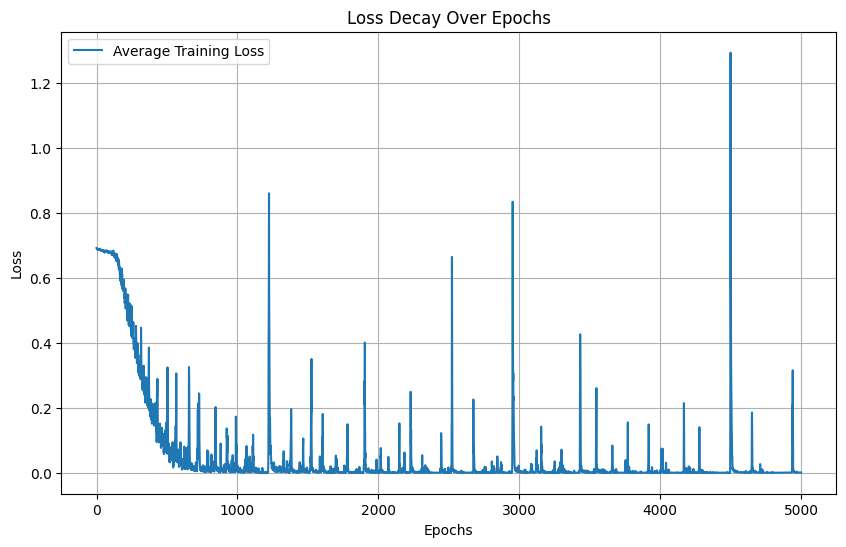

In [67]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, roc_auc_score
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout, target):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        if 'behavior' in target:
            self.fc = nn.Sequential(
                nn.Linear(hidden_size, hidden_size // 2),
                nn.Sigmoid(),
                nn.Linear(hidden_size // 2, 2)  # 2 classes para CrossEntropy
            )
        else:
            self.fc = nn.Linear(hidden_size, 1)  # Para regressão

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        output = self.fc(hidden[-1])
        return output


# Parâmetros de entrada
input_size = X_train.shape[2]  # Número de características de entrada
hidden_size = 64               # Tamanho do estado oculto
num_layers = 3                 # Número de camadas LSTM
dropout = 0.2                  # Taxa de dropout
target = 'behavior_target'     # Tipo de alvo para classificação binária
epochs = 5000
batch_size = 32
learning_rate = 0.001

# Criação do modelo
model = LSTMModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout, target=target)
print(model)

# Definindo o otimizador
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Critério para classificação binária (CrossEntropy)
criterion = nn.CrossEntropyLoss()

# Criando o DataLoader corretamente (sem embaralhamento, já que é série temporal)
train_loader = DataLoader(
    TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long)),
    batch_size=batch_size, shuffle=False
)

# Dicionário para armazenar as perdas
average_losses = {epoch: [] for epoch in range(epochs)}

# Loop de treinamento
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        
        if target == 'behavior_target':  # Flatten para CrossEntropyLoss
            output = output.view(-1, 2)  # Saída com 2 classes
            y_batch = y_batch.view(-1)  # Flatten y_batch

        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    average_losses[epoch].append(avg_loss)
    if epoch % 200  == 0: 
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    # Evaluation on test data
    model.eval()
    test_loader = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long)), batch_size=batch_size, shuffle=False)
    predictions = []
    true_values = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            output = model(X_batch)
            if 'behavior' in target:
                _, predicted = torch.max(output, 1)  # Get the class with highest probability
            else:
                predicted = output
            predictions.append(predicted.numpy())
            true_values.append(y_batch.numpy())
            
    predictions = np.concatenate(predictions, axis=0)
    true_values = np.concatenate(true_values, axis=0)

    # Calculate error based on target
    if 'price' in target:
        error = mean_squared_error(true_values, predictions)
    else:
        error = roc_auc_score(true_values, predictions)
        

# Plotting the loss decay graph at the end of training
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), [np.mean(loss) for loss in average_losses.values()], label='Average Training Loss')
plt.title(f'Loss Decay Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [51]:
predictions

array([1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0],
      dtype=int64)

In [63]:
X_test.shape

(63, 30, 504)

In [52]:
true_values

array([1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1],
      dtype=int64)

In [60]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


x_teste_tenso = torch.tensor(X_test, dtype=torch.float32)
y_teste_tenso =torch.tensor(y_test, dtype=torch.long)


model.eval()
with torch.no_grad():
    y_pred = model(x_teste_tenso)
    _, y_pred_1 = torch.max(y_pred, 1)
    
    


In [62]:
y_pred_1.shape


torch.Size([63])

In [57]:
y_pred

tensor([[-1.8100,  1.9923],
        [-0.0437,  0.0626],
        [ 2.7114, -2.7670],
        [ 1.4058, -1.3722],
        [ 0.6926, -0.6159],
        [ 2.3740, -2.4123],
        [-3.0176,  3.2952],
        [ 1.8870, -1.8796],
        [ 2.8068, -2.8558],
        [ 3.0198, -3.0871],
        [-1.7802,  1.9820],
        [-2.8672,  3.1302],
        [ 2.1678, -2.1869],
        [ 2.3394, -2.3566],
        [ 1.2012, -1.1384],
        [ 1.4232, -1.3890],
        [ 2.1702, -2.1903],
        [ 2.7758, -2.8283],
        [ 2.9911, -3.0582],
        [ 0.8982, -0.8706],
        [-2.8161,  3.0749],
        [-2.1767,  2.3899],
        [ 2.3357, -2.3694],
        [ 1.0525, -1.0127],
        [-0.9177,  1.0187],
        [-2.2534,  2.4468],
        [ 1.0014, -1.0276],
        [ 2.3311, -2.3633],
        [ 1.7359, -1.7374],
        [ 2.7437, -2.7947],
        [ 0.1000, -0.0151],
        [-2.6626,  2.9161],
        [-2.3966,  2.6307],
        [ 1.9700, -1.9880],
        [-0.9189,  1.0727],
        [ 0.1303, -0

In [ ]:
    


# Gerar matriz de confusão
cm = confusion_matrix(y_teste_tenso, y_pred_1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')

# Mostrar a matriz de confusão
plt.title("Confusion Matrix")
plt.show()

# Gerar relatório de métricas
report = classification_report(y_teste_tenso, y_pred_1, target_names=["Class 0", "Class 1"])
print("Classification Report:")
print(report)

NameError: name 'confusion_matrix' is not defined